Exploration of using Javier's dataset consisting of a power sweep for a 10-span system as an example of how to augment GPs with physical model priors. 
PLAN: 
* implement physical model-enhanced (homoscedastic) GP model for toy SNR(Pch) dataset 
* compare results with library, such as GPy
* compare results with own GP implementation with no physical model 
STEPS: 
1. Implement homoscedastic GP regression from stratch (object-orientated)
2. Implement a modified version in which physical models are used in fitting process and compare

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import GPy
import time

In [53]:
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [68]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]

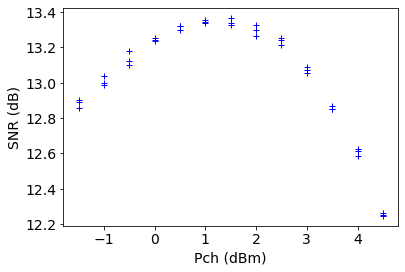

In [69]:
plt.plot(pch, snr, 'b+')
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.show()

In [61]:
print(min(pch))

-1.0


Data consists of time series measurements of SNR as a function of Pch - values are recorded in 0.5 dBm increments, with multiple recorded values of SNR at each Pch. 

We can define a GP model using the GPy library, a powerful open source Gaussian Process library.

In [70]:
snr = snr.reshape(len(snr),1)
pch = pch.reshape(len(pch),1)

In [72]:
kern_gpy = GPy.kern.RBF(1) + GPy.kern.White(1) 
m1 = GPy.models.GPRegression(pch,snr,kern_gpy)
start = time.time()
m1.optimize()
end = time.time()
print("GPy took " + str(end-start) + "s")
lml_sgp = m1.log_likelihood()
print("GPy LML = " + str(lml_sgp))

GPy took 0.06316375732421875s
GPy LML = 75.07804853891383


In [73]:
mu_gpy, var_gpy = m1.predict(pch)  # extract predictive mean and variance from GPy model 
std_gpy = var_gpy**0.5
mu_gpy_p = mu_gpy + std_gpy*2
mu_gpy_n = mu_gpy - std_gpy*2

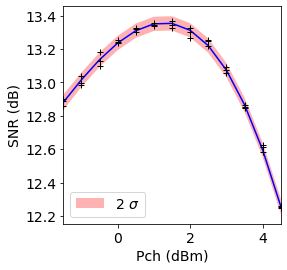

In [74]:
f, ax = plt.subplots()
ax.plot(pch, mu_gpy, color = 'b')
ax.plot(pch, snr,'k+')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_gpy_p,
                            (mu_gpy_n)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [71]:
class phys_GP:
    def __init__(self, x, y, kernel, phys_model)
        self.x = x 
        self.y = y
        self.kernel = kernel
        self.phys_model = phys_model
    def fit(self):
        
    

SyntaxError: invalid syntax (<ipython-input-71-cb82f3e8c67e>, line 2)